In [1]:
import os
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from difflib import SequenceMatcher
import math
import re
from collections import Counter
import json

# Load Data from Dump

In [2]:
DUMP_PATH = "./dumps/Fri Oct 07 15 25 19 2022.json"

In [3]:
f = open(DUMP_PATH)
  
data = json.load(f)

f.close()

In [4]:
ASCII_CHAR_COUNT = 256

In [5]:
class TextData:
    def __init__(self, asciiCodes):
        self.length = len(asciiCodes)
        self.fTable = self.getAsciiCodesFTable(asciiCodes)
        self.str = self.cvtAsciiCodesToStr(asciiCodes)
        self.bins = self.cvtStrToBins(asciiCodes)
        
    def getAsciiCodesFTable(self, asciiCodes):
        fTable = [0] * ASCII_CHAR_COUNT
        
        for asciiCode in asciiCodes:
            fTable[asciiCode] += 1
            
        return fTable
    
    def cvtAsciiCodesToStr(self, asciiCodes):
        # ref: https://www.reddit.com/r/learnpython/comments/r1n6oh/how_do_i_print_extended_ascii_codes/
        return bytes(asciiCodes).decode('cp437')
    
    def cvtStrToBins(self, asciiCodes):
        return "".join(["{0:08b}".format(i) for i in asciiCodes])

In [6]:
class Result:
    def __init__(
        self,
        plainTextId,
        cipherTextAsciiCodes,
        encRtMean,
        encRtPopStdDev,
        decRtMean,
        decRtPopStdDev
    ):
        self.plainTextId = plainTextId
        self.cipherText = TextData(cipherTextAsciiCodes)
        self.encRtMean = encRtMean
        self.encRtPopStdDev = encRtPopStdDev
        self.decRtMean = decRtMean
        self.decRtPopStdDev = decRtPopStdDev


In [7]:
PT_DATA = [TextData(asciiCodes) for asciiCodes in data["plainTexts"]]

In [8]:
rc4Result = []
for d in data["rc4"]:
    rc4Result.append(Result(
        plainTextId = d["plainTextId"],
        cipherTextAsciiCodes = d["cipherText"],
        encRtMean = d["encRtMean"],
        encRtPopStdDev = d["encRtPopStdDev"],
        decRtMean = d["decRtMean"],
        decRtPopStdDev = d["decRtPopStdDev"]
    ))

In [9]:
RES_DATA = {
    "rc4": rc4Result
}

# Plot ASCII Character Frequency

In [10]:
def plotAsciiCodeFreqMap(data, cipherName):
    if len(data) == 0:
        return
    
    colCount = 2
    rowCount = len(data)
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 30))
    
    fig.suptitle(f"ASCII Character Frequency {cipherName}", fontsize=16)

    x = np.array(range(0, ASCII_CHAR_COUNT))
    
    for i in range(0, rowCount):
        ax[i, 0].plot(x, np.array(PT_DATA[data[i].plainTextId].fTable))
        ax[i, 0].set_title(f"Plain Text ({PT_DATA[data[i].plainTextId].length})")
        ax[i, 0].set_xlabel('ASCII Code')
        ax[i, 0].set_ylabel('Frequency')
        
        ax[i, 1].plot(x, np.array(data[i].cipherText.fTable))
        ax[i, 1].set_title(f"Cipher Text ({data[i].cipherText.length})")
        ax[i, 1].set_xlabel('ASCII Code')
        ax[i, 1].set_ylabel('Frequency')

    fig.tight_layout()
    
    fig.subplots_adjust(top=0.95)
    
    plt.show()

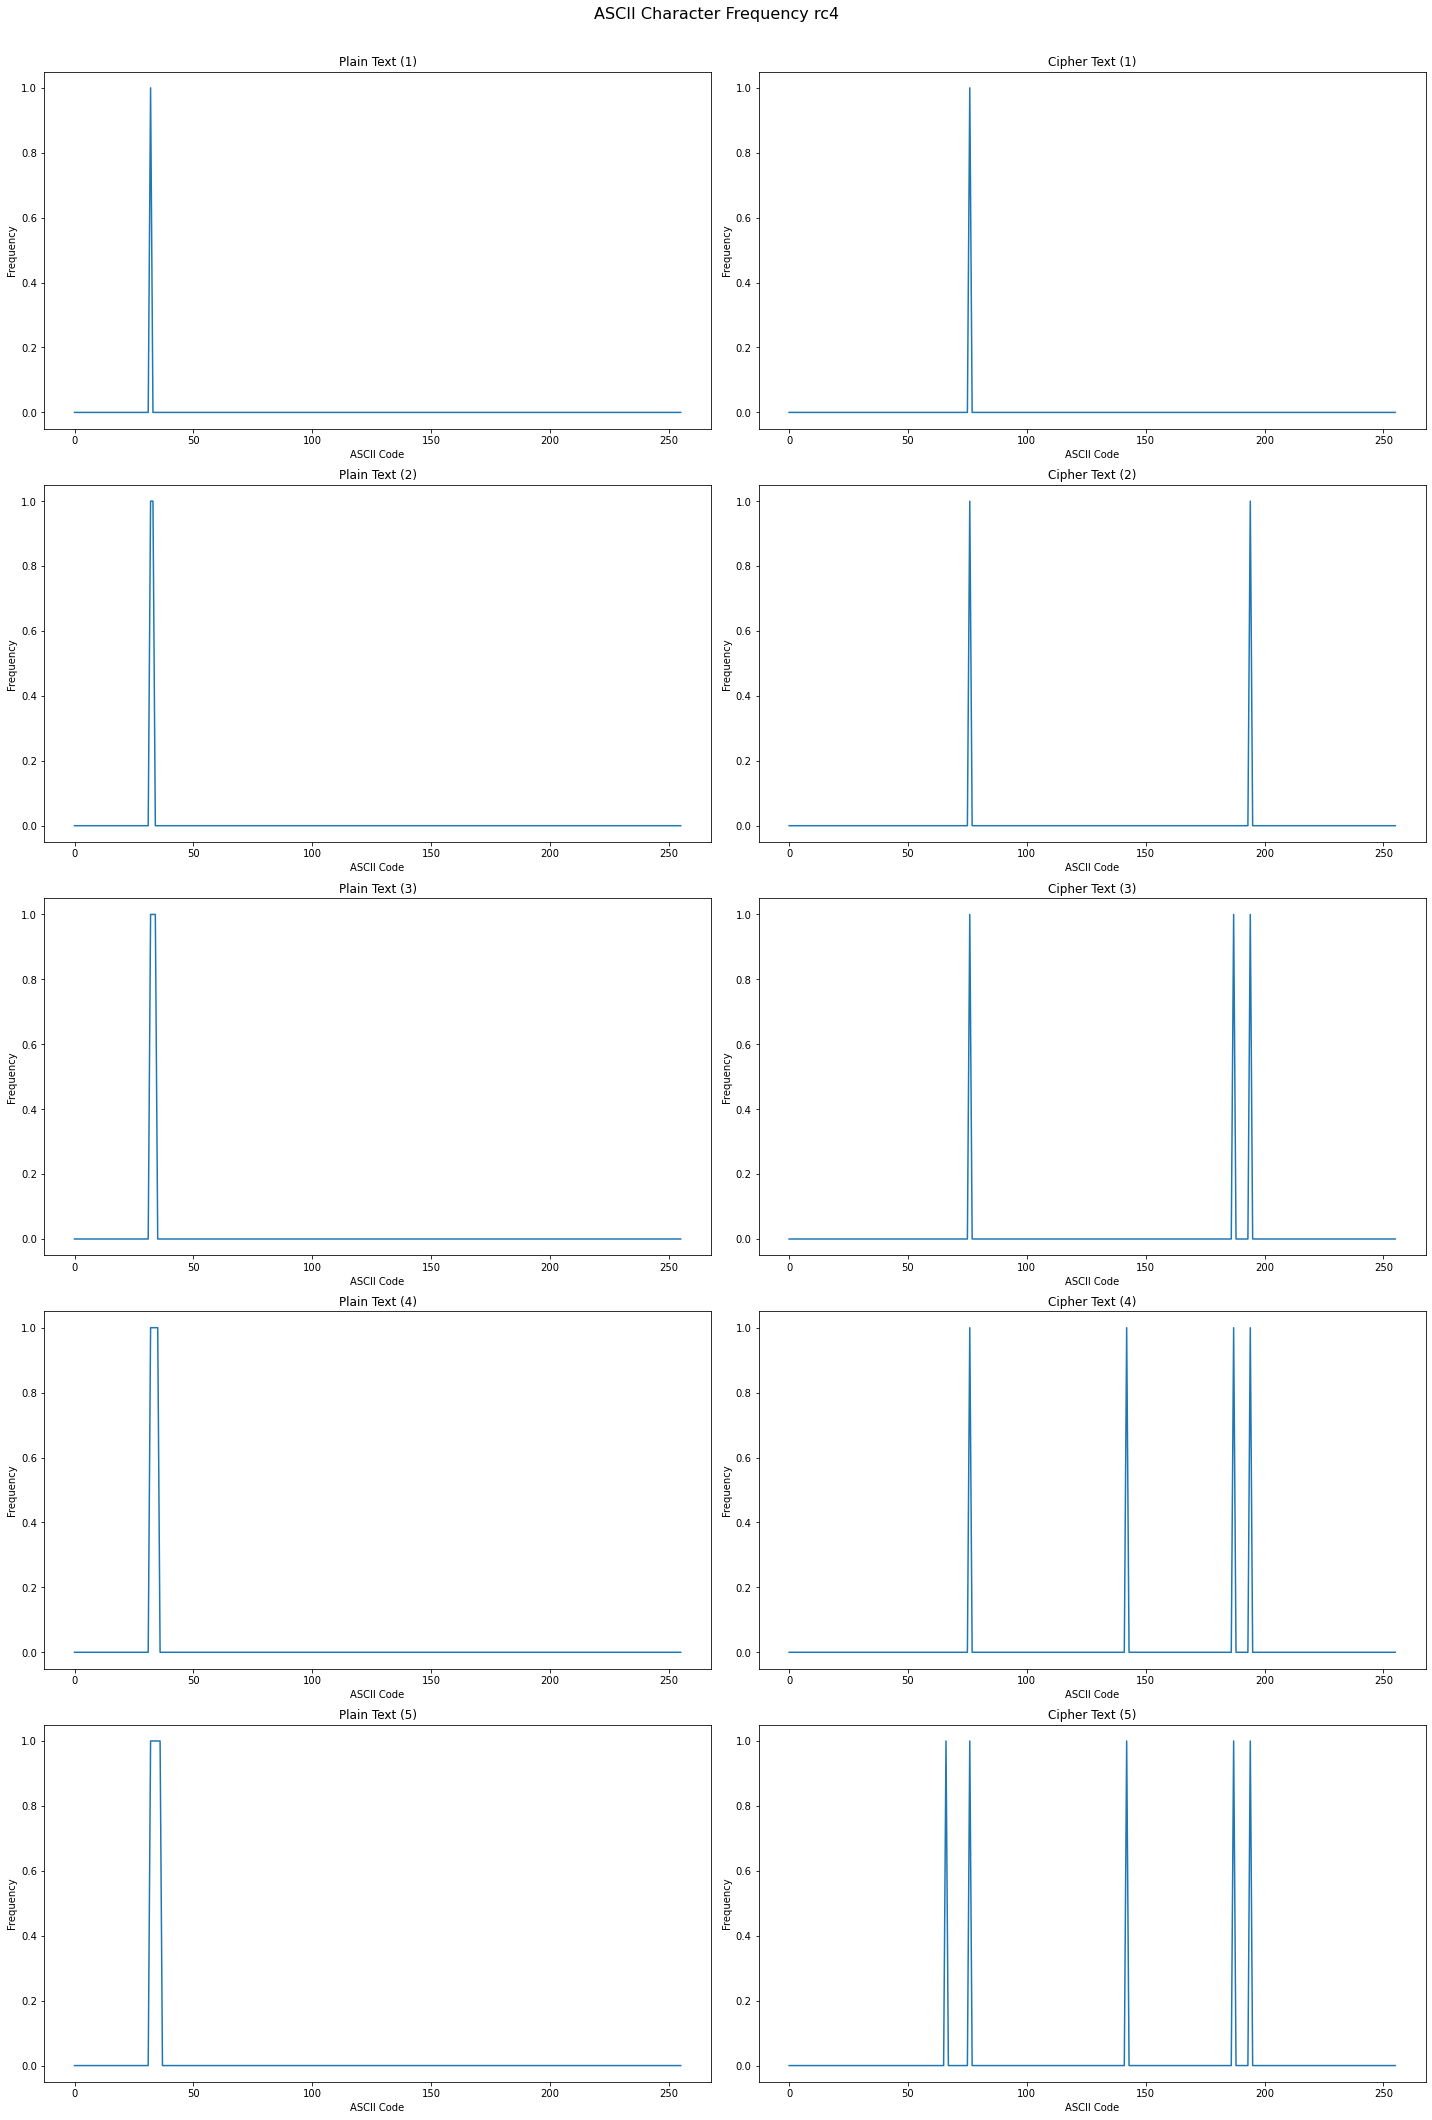

In [11]:
plotAsciiCodeFreqMap(RES_DATA["rc4"], "rc4")

# Measure Plain Text and Cipher Text Similarities

In [12]:
def getSequenceMatcherRatio(a, b):
    return SequenceMatcher(None, a, b).ratio()

def getCosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def textToVector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)


def getCosineSimilarity(a, b):
    return getCosine(
        textToVector(a),
        textToVector(b)
    )

In [13]:
def measurePlainTextAndCipherTextSimilarities(data):
    plainTextLengths = [PT_DATA[d.plainTextId].length for d in data]
    cipherTextLengths = [d.cipherText.length for d in data]
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "cipher text length": cipherTextLengths,
        "sequence matcher": [getSequenceMatcherRatio(PT_DATA[d.plainTextId].str, d.cipherText.str) for d in data],
        "cosine similarity": [getCosineSimilarity(PT_DATA[d.plainTextId].str, d.cipherText.str) for d in data]
    })

In [14]:
pd.set_option('display.max_rows', None)

In [15]:
measurePlainTextAndCipherTextSimilarities(RES_DATA["rc4"])

,plain text length,cipher text length,sequence matcher,cosine similarity
0,1,1,0.0,0.0
1,2,2,0.0,0.0
2,3,3,0.0,0.0
3,4,4,0.0,0.0
4,5,5,0.0,0.0


# Print Count of Zeros and Ones

In [16]:
def countZerosAndOnes(str):
    oneCount = 0
    for c in str:
        if c == "1":
            oneCount += 1
    return abs(len(str) - oneCount), oneCount

def countZeroesAndOnesInPlainTextAndCipherText(data):
    plainTextLengths = [PT_DATA[d.plainTextId].length for d in data]
    cipherTextLengths = [d.cipherText.length for d in data]
    
    ptOneCounts = []
    ptZeroCounts = []
    ctOneCounts = []
    ctZeroCounts = []
    
    for i in range(0, len(data)):
        ptZeroCount, ptOneCount = countZerosAndOnes(PT_DATA[data[i].plainTextId].bins)
        ptZeroCounts.append(ptZeroCount)
        ptOneCounts.append(ptOneCount)
        
        ctZeroCount, ctOneCount = countZerosAndOnes(data[i].cipherText.bins)
        ctZeroCounts.append(ctZeroCount)
        ctOneCounts.append(ctOneCount)
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "cipher text length": cipherTextLengths,
        
        "plain text total bits": [len(PT_DATA[d.plainTextId].bins) for d in data],
        "cipher text total bits": [len(d.cipherText.bins) for d in data],
        
        "plain text 0s": ptZeroCounts,
        "plain text 1s": ptOneCounts,
        
        "cipher text 0s": ctZeroCounts,
        "cipher text 1s": ctOneCounts,
    })

In [17]:
countZeroesAndOnesInPlainTextAndCipherText(RES_DATA["rc4"])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,1,1,8,8,7,1,5,3
1,2,2,16,16,13,3,10,6
2,3,3,24,24,19,5,12,12
3,4,4,32,32,24,8,16,16
4,5,5,40,40,30,10,22,18


# Plot Running Times Mean

In [18]:
def plotEncryptDecryptRunningTimesMean():
    plainTextLengths = [i.length for i in PT_DATA]
    
    rc4EncData = [i.encRtMean for i in RES_DATA["rc4"]]

    rc4DecData = [i.decRtMean for i in RES_DATA["rc4"]]
    
    # left col: encrypt and right col: decrypt
    colCount = 2
    rowCount = 1
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 7))
    
    fig.suptitle(f"Running Time Mean", fontsize=16)

#     ax[0].plot(plainTextLengths, np.array(desEncData), color='r', label="des")
    ax[0].plot(plainTextLengths, np.array(rc4EncData), color='g', label="rc4")
    ax[0].set_title(f"Encrypt")
    ax[0].set_xlabel('Plain Text Length')
    ax[0].set_ylabel('Running Time Mean')
    ax[0].legend(loc="upper left")
    
#     ax[1].plot(plainTextLengths, np.array(desDecData), color='r', label="des")
    ax[1].plot(plainTextLengths, np.array(rc4DecData), color='g', label="rc4")
    ax[1].set_title(f"Decrypt")
    ax[1].set_xlabel('Plain Text Length')
    ax[1].set_ylabel('Running Time Mean')
    ax[1].legend(loc="upper left")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

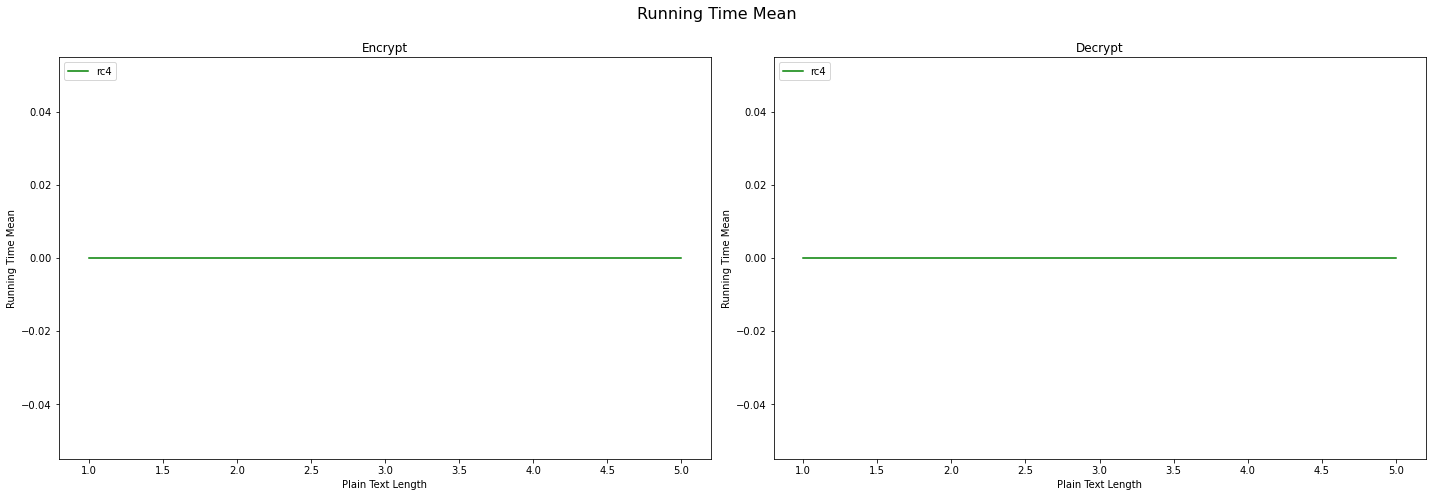

In [19]:
plotEncryptDecryptRunningTimesMean()

# Plot Running Times Population Standard Deviation

In [20]:
def plotEncryptDecryptRunningTimesPopStdDev(data):
    plainTextLengths = [i.length for i in PT_DATA]
    
    rc4EncData = [i.encRtPopStdDev for i in RES_DATA["rc4"]]

    rc4DecData = [i.decRtPopStdDev for i in RES_DATA["rc4"]]
    
    # left col: encrypt and right col: decrypt
    colCount = 2
    rowCount = 1
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 7))
    
    fig.suptitle(f"Running Time Population Standard Deviation", fontsize=16)

#     ax[0].plot(plainTextLengths, np.array(desEncData), color='r', label="des")
    ax[0].plot(plainTextLengths, np.array(rc4EncData), color='g', label="rc4")
    ax[0].set_title(f"Encrypt")
    ax[0].set_xlabel('Plain Text Length')
    ax[0].set_ylabel('Running Time Population Standard Deviation')
    ax[0].legend(loc="upper left")
    
#     ax[1].plot(plainTextLengths, np.array(desDecData), color='r', label="des")
    ax[1].plot(plainTextLengths, np.array(rc4DecData), color='g', label="rc4")
    ax[1].set_title(f"Decrypt")
    ax[1].set_xlabel('Plain Text Length')
    ax[1].set_ylabel('Running Time Population Standard Deviation')
    ax[1].legend(loc="upper left")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

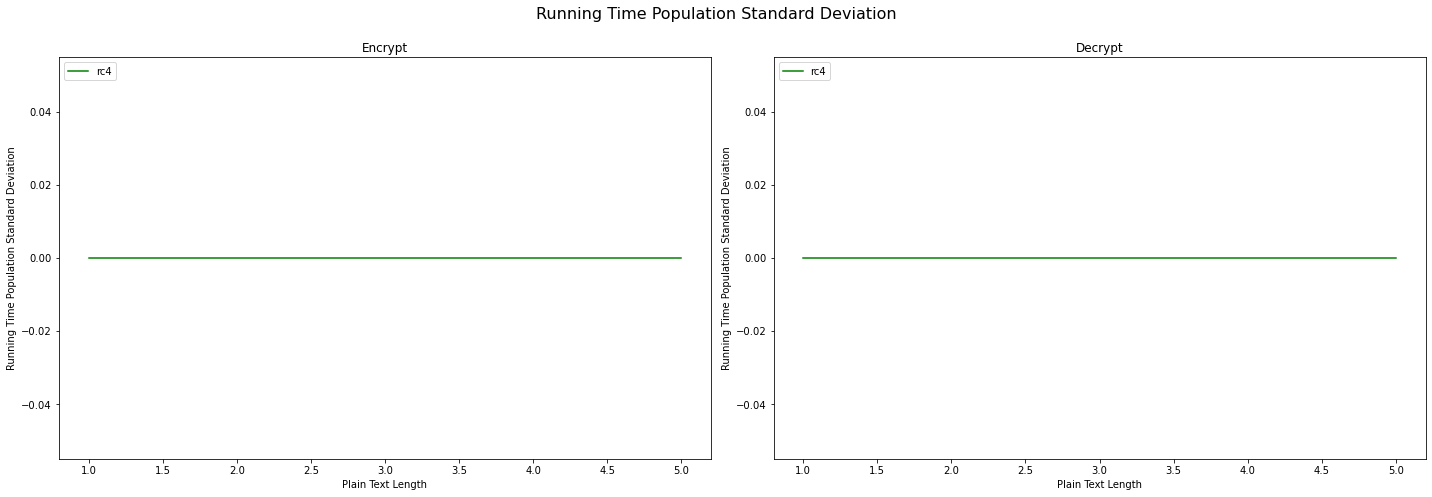

In [21]:
plotEncryptDecryptRunningTimesPopStdDev(data)

# Conclusion

RC4 is

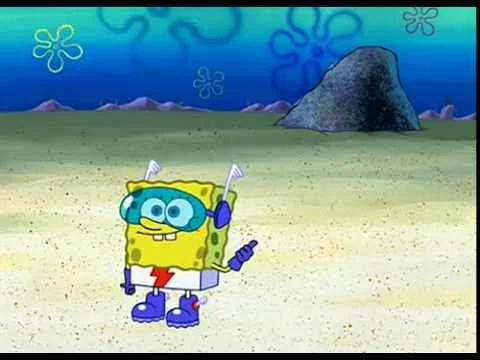